In [1]:
import functions
from pprint import pprint
import matplotlib.pyplot as plt
import sys, operator

In [2]:
# The GTO data from Head-Gordon et al for a subset of functionals
hg_data = functions.get_HG_data("hg_data.csv", functionals=["ccsd(t)", "pbe", "pbe0", "spw92"])

# The multiwavelet data, first derivative finite difference based on dipoles
mw_data = functions.get_mw_pol_fdu("mw_rawdata.csv")

In [3]:
# All data are stored in dictionaries. For example, the HG data for AlF is
hg_data["alf"]

{'ccsd(t)': {'diagonal': [5.971, 5.971, 5.132], 'mean': 5.691333333333333},
 'pbe': {'diagonal': [6.292, 6.292, 5.656], 'mean': 6.079999999999999},
 'pbe0': {'diagonal': [6.248, 6.248, 5.378], 'mean': 5.958000000000001},
 'spin': 'NSP',
 'spw92': {'diagonal': [6.154, 6.154, 5.59], 'mean': 5.966}}

In [4]:
# Reproduce their published MRE values to make sure the data we have is correct
molecules_all = [mol for mol in hg_data.keys()]
for func in ["pbe", "pbe0"]:
    # Get the relative errors for each pol component
    mre_xx = sum([100 * (hg_data[mol][func]["diagonal"][0] / hg_data[mol]["ccsd(t)"]["diagonal"][0] - 1) for mol in molecules_all]) / len(molecules_all)
    mre_yy = sum([100 * (hg_data[mol][func]["diagonal"][1] / hg_data[mol]["ccsd(t)"]["diagonal"][1] - 1) for mol in molecules_all]) / len(molecules_all)
    mre_zz = sum([100 * (hg_data[mol][func]["diagonal"][2] / hg_data[mol]["ccsd(t)"]["diagonal"][2] - 1) for mol in molecules_all]) / len(molecules_all)
    
    mre_tot = sum([mre_xx, mre_yy, mre_zz]) / 3
    print(func, mre_tot)

('pbe', 7.906210933634736)
('pbe0', 2.836532505810867)


In [5]:
## Now produce some plots 
## Top axes: The relative error between GTO and MW polarizabilities for each molecule, using MW
##           as reference: RE = (GTO - MW) / MW * 100.
##   
##           Color coding: blue for non-spin polarized molecules
##                         red  for     spin polarized molecules
##  
## Bottom axes: Compare both MW and GTO polarizabilities to the CCSD(t) reference provided by HG et al.
##              using the CC results as reference.
##   
##              Color coding: black for GTO relative errors
##                            blue  for non-spin polarized MW relative errors
##                            red   for     spin polarized MW relative errors

## First for the PBE functional, then for LDA(MW)/SPW92(GTO)

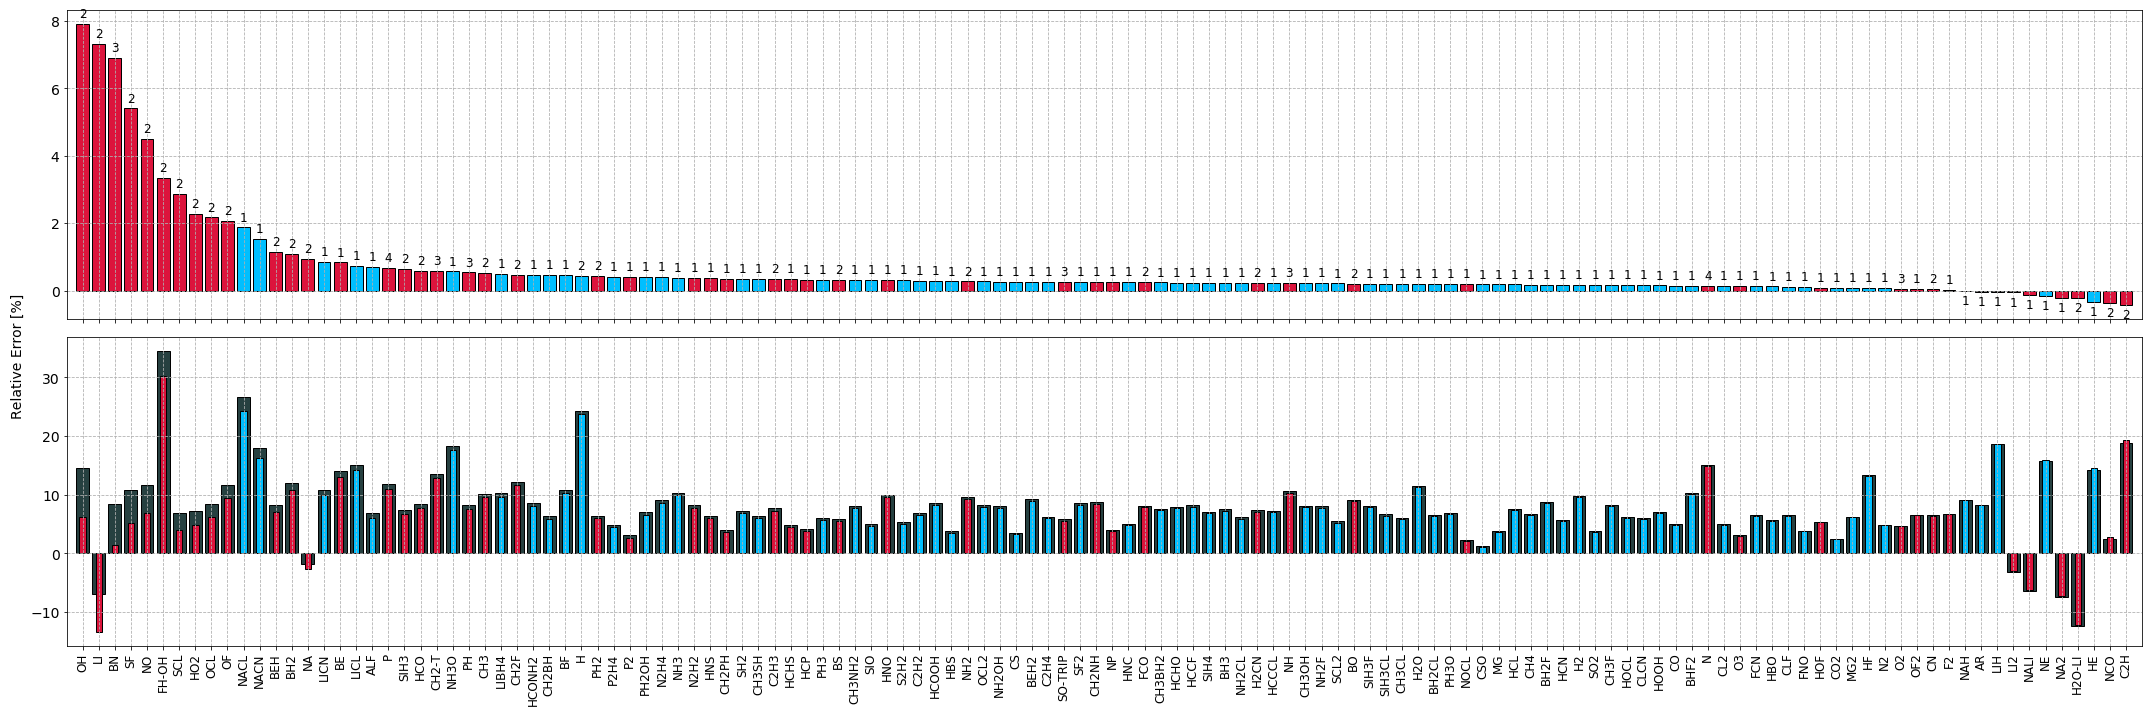

In [20]:
# 4 molecules () are missing from the MW dataset, so we base all comparisons on the keys of mw_data
molecules = [mol for mol in mw_data.keys()]

# Define the xticks for the plots
xticks = range(len(molecules))

# Now extract the data we want
rel_err_pbe    = [100 * (hg_data[mol]["pbe"]["mean"] / mw_data[mol]["pbe"]["mean"]     - 1) for mol in molecules]
rel_err_mw_cc  = [100 * (mw_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]
rel_err_gto_cc = [100 * (hg_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]

# Sort data based on the PBE relative error results, by zip-sort-unzip
molecules_sorted, rel_err_pbe_sorted, rel_err_mw_cc_sorted, rel_err_gto_cc_sorted = zip(*sorted(zip(molecules, rel_err_pbe, rel_err_mw_cc, rel_err_gto_cc), reverse=True, key=operator.itemgetter(1)))

# Define bar colors based on spin polarization
spin_colors = ["deepskyblue" if hg_data[mol]["spin"] == "NSP" else "crimson" for mol in molecules_sorted]

# Set up the figure with subplots
fontsize = 14
width=0.8

fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), nrows=2, ncols=1, sharex=True)
ax1.tick_params(axis="y", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)

# Define two "ghost" labels, to fit in a text that works as a common label for both axes
ax1.set_ylabel(" ", fontsize=20)
ax2.set_ylabel(" ", fontsize=20)
fig.text(0.01, 0.5, "Relative Error [%]", fontsize=fontsize, rotation=90, ha="center", va="center")

# Plot data
for i in range(len(molecules_sorted)):
    mult = mw_data[molecules_sorted[i]]["multiplicity"]
    # Shift the multiplicities by a small factor to not overlap with bar plot
    offset = 0.3 if rel_err_pbe_sorted[i] > 0 else -0.3

    # Plot multiplicities
    ax1.text(xticks[i], rel_err_pbe_sorted[i]+offset, str(mult), ha="center", va="center", fontsize=12)
    
    # Plot GTO compared to MW
    ax1.bar(xticks[i], rel_err_pbe_sorted[i], color=spin_colors[i], edgecolor="black", width=width)

    # Plot MW and GTO compared to CCSD(T)
    ax2.bar(xticks[i], rel_err_gto_cc_sorted[i], color="#264040", edgecolor="black", width=width)
    ax2.bar(xticks[i], rel_err_mw_cc_sorted[i], color=spin_colors[i], edgecolor="black", width=0.5*width)

ax2.set_xlim(-1, len(molecules))
ax1.grid(True, linestyle="--")
ax2.grid(True, linestyle="--")

# Place the molecule names on the xtick positions, rotation by 90 degrees
plt.xticks(xticks, [mol.upper() for mol in molecules_sorted], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

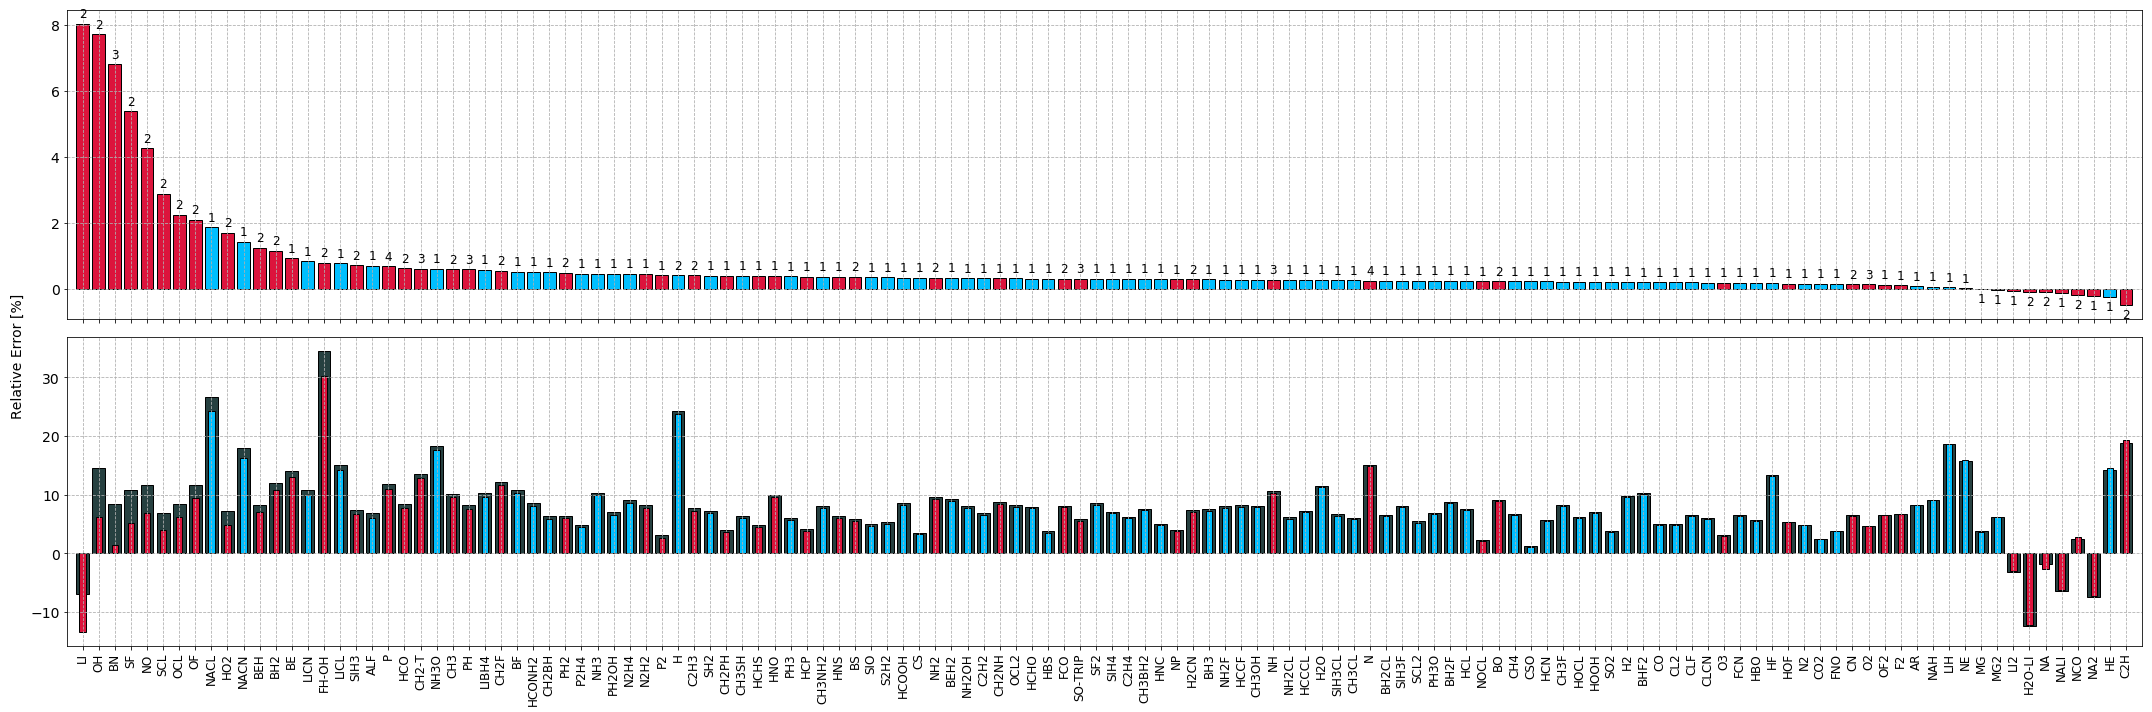

In [6]:
# Repeat plot but for LDA data
molecules = [mol for mol in mw_data.keys()]

xticks = range(len(molecules))

rel_err_lda    = [100 * (hg_data[mol]["spw92"]["mean"] / mw_data[mol]["lda"]["mean"]     - 1) for mol in molecules]
rel_err_mw_cc  = [100 * (mw_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]
rel_err_gto_cc = [100 * (hg_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]

molecules_sorted, rel_err_lda_sorted, rel_err_mw_cc_sorted, rel_err_gto_cc_sorted = zip(*sorted(zip(molecules, rel_err_lda, rel_err_mw_cc, rel_err_gto_cc), reverse=True, key=operator.itemgetter(1)))

spin_colors = ["deepskyblue" if hg_data[mol]["spin"] == "NSP" else "crimson" for mol in molecules_sorted]

fontsize = 14
width=0.8
fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), nrows=2, ncols=1, sharex=True)
ax1.tick_params(axis="y", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)

ax1.set_ylabel(" ", fontsize=20)
ax2.set_ylabel(" ", fontsize=20)
fig.text(0.01, 0.5, "Relative Error [%]", fontsize=fontsize, rotation=90, ha="center", va="center")

for i in range(len(molecules_sorted)):
    mult = mw_data[molecules_sorted[i]]["multiplicity"]
    offset = 0.3 if rel_err_lda_sorted[i] > 0 else -0.3

    ax1.text(xticks[i], rel_err_lda_sorted[i]+offset, str(mult), ha="center", va="center", fontsize=12)
    
    ax1.bar(xticks[i], rel_err_lda_sorted[i], color=spin_colors[i], edgecolor="black", width=width)

    ax2.bar(xticks[i], rel_err_gto_cc_sorted[i], color="#264040", edgecolor="black", width=width)
    ax2.bar(xticks[i], rel_err_mw_cc_sorted[i], color=spin_colors[i], edgecolor="black", width=0.5*width)

ax2.set_xlim(-1, len(molecules))
ax1.grid(True, linestyle="--")
ax2.grid(True, linestyle="--")

plt.xticks(xticks, [mol.upper() for mol in molecules_sorted], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()